In [ ]:
! pip install LightPipes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.2 MB/s eta 0:00:00


In [ ]:
# Importando as bibliotecas
from LightPipes import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

In [ ]:
# Definindo os campo e constante da Eq.32
def Lambda(M,N,sigma,delta):
  a = 1/(4*sigma**2) #
  b = 1/(2*delta**2) #
  c = 2*np.sqrt( a**2 + 2*a*b )
  L = ( np.pi/(a + b + c/2) )*( (a + b - c/2)/( a + b + c/2 ) )**( abs(M)/2 + N )
  return L

def Laguerre_G(n,m,sigma,delta):
    a = 1/(4*sigma**2) # [L]^-2
    b = 1/(2*delta**2) # [L]^-2
    c = 2*np.sqrt( a**2 + 2*a*b )
    w = np.sqrt( 2/c )

    x = np.arange(-N/2, N/2,1)*dx
    xx,yy = np.meshgrid(x,x)

    r    = np.sqrt(xx**2+yy**2)
    C    = np.sqrt(2*math.factorial(jj)/(np.pi*math.factorial(n+abs(m))))
    PL   = sp.special.assoc_laguerre(2*r**2/w**2,n,abs(m))
    Fase = np.exp(- 1j*m*np.arctan2(yy,xx) )

    LG   = C*1/w*(r*np.sqrt(2)/w)**abs(m)*PL*np.exp(-r**2/w**2)*Fase
    return LG

In [ ]:
#Parâmetros do feixe GSM
sigma = .2*mm        # largura do feixe
delta = .2*mm        # comprimento de coerência
L = 10
P = 5

lambd = 620*nm        # light wavelength
N     = 2**7          # Dimensão
dx    = 20*um         # Tamanho do pixel

# Gerando os campos para a soma incoerente
Numero_de_Soma_Inc = (2*L+1)*(P+1)
Campo =  np.exp( 1j*np.zeros((N,N,Numero_de_Soma_Inc))) # Campo

i = 0
for j in range(-L,L+1):
  for jj in range(P+1):
    Campo[:,:,i] = np.sqrt(Lambda(j,jj,sigma,delta))*Laguerre_G(n=jj,m=j,sigma=sigma,delta=delta)
    i += 1



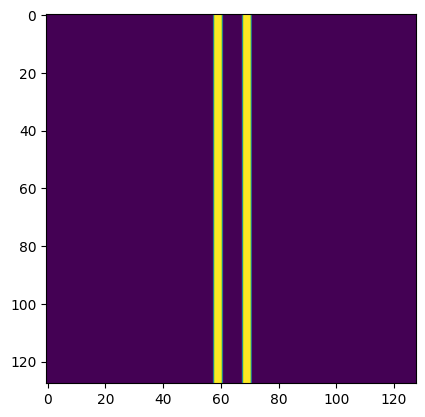

In [ ]:
# Inicialização

class grid:
  pass
grid.N  = N;
grid.dx = dx
grid.x  = np.arange(-grid.N/2,grid.N/2,1)*grid.dx;
[grid.xx,grid.yy] = np.meshgrid(grid.x,grid.x);

d0 = .2*mm;
a0 = .06*mm;
# make slit
fslit = (np.ones_like(grid.xx)*(abs(grid.xx+(d0/2))<=a0/2) +
         np.ones_like(grid.xx)*(abs(grid.xx-(d0/2))<=a0/2));
plt.imshow(fslit);plt.show()

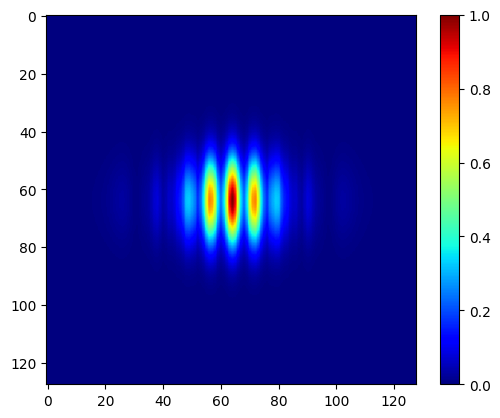

In [ ]:
F  = Begin(dx*100,lambd,N)
# passando pelas fendas --> soma incoerente
imagem =[0]
aux4 = np.exp(1j*np.zeros((N,N,i)))
FF = F.copy(F)

for ii in range(i):
  FF.field = Campo[:,:,ii]*fslit
  FF1      = Forvard(3*cm,FF)
  aux4[:,:,ii] = Intensity(FF1)
  imagem     += Intensity(FF1)
imagem = imagem/imagem.max()
plt.imshow(imagem,cmap = "jet");plt.colorbar();plt.show()

In [ ]:

### Função da Suavização ############
def SUAVE(media, linha):
  novalista = []
  for i in range(media ,2**9,1):
    b = imagem[linha,i-media:i]
    AA = sum(b)/media
    novalista.append(AA)
  return np.array(novalista)

### Função para encontrar os maximos e minimos ############
def MM(suavizar,linha):
  maxi2 = SUAVE(suavizar,linha).max()
  posiçao2 = 0
  for i in SUAVE(suavizar,linha):
    if i == maxi2:
      break
    posiçao2 +=1

    #### Encontrar o valor mínimo local a Direita parti do maximo global
  mini = 0
  Vimax = SUAVE(suavizar,linha)[posiçao2:2**9]
  for i in range(len(Vimax)):
    if i == len(Vimax)-1:
      break
    if Vimax[i] > Vimax[i+1]:
      mini = Vimax[i+1]
    elif Vimax[i] < Vimax[i+1]:
      mini = Vimax[i]
      break
  # Vamos encontrar o posição no qual temos mínimo
  PMin = 0
  for i in Vimax:
    if i == mini:
      break
    PMin += 1
  posiçaomin = posiçao2 + PMin -1
    #######################################################################
    #### Encontrar o valor mínimo local a ESQUERDA a parti do maximo lobal
  miniE = 0
  xamiV = SUAVE(suavizar,linha)[0:posiçao2]
    #########################################################
  for i in range(len(xamiV)):
    i += 1
    if i == len(xamiV)-1:
      break
    if xamiV[-i] > xamiV[-i-1]:
      miniE = xamiV[-i-1]
    elif xamiV[-i] < xamiV[-i-1]:
      miniE = xamiV[-i]
      break
  # Vamos encontrar o posição no qual temos mínimo
  PMinE = 0
  for i in range(len(xamiV)):
    i+=1
    if xamiV[-i] == miniE:
      break
    PMinE += 1
  posiçaominE = posiçao2 - PMinE

  if miniE > mini:
    posiçaomin = posiçaominE
    mini       = miniE
  # [0] = Valor max,[1] = Posição max ,[2] = Valor Min,[3] = Posição Min
  return maxi2, posiçao2, mini, posiçaomin  #,miniE, posiçaominE

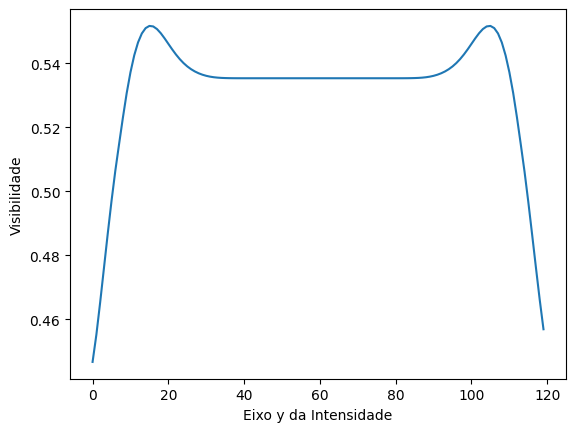

Valor medio da grau de coerencia/Visibilidade  0.5314894817991416


In [ ]:
# A VISIBILIDADE
VisibilidadeN = []
q = 2
qq = 0
for j in range(grid.N//2 -20,grid.N//2 +60):
  V = ( MM(q,j)[0]-MM(q,j)[2])/(MM(q,j)[0]+MM(q,j)[2])
  VisibilidadeN.append(V)
  qq+=1

plt.plot(VisibilidadeN)
plt.xlabel('Eixo y da Intensidade')
plt.ylabel("Visibilidade")
plt.show()
print("Valor medio da grau de coerencia/Visibilidade ",sum(VisibilidadeN)/qq)